# Test

This is just a marktest script for the idea of creating a picture-to-recipe llm

In [1]:
import os
import google.generativeai as genai
from langchain_google_genai import ChatGoogleGenerativeAI

api_key = os.environ.get("GOOGLE_API_KEY")
api_key_tavily = os.environ.get("TAVILY_API_KEY")
genai.configure(api_key=api_key)

os.environ["GOOGLE_API_KEY"] = api_key
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature = 0)

In [2]:
%pip install -U -q google-genai ultralytics

import json

import cv2
import ultralytics
from google import genai
from google.genai import types
from PIL import Image
from ultralytics.utils.downloads import safe_download
from ultralytics.utils.plotting import Annotator, colors

ultralytics.checks()

Ultralytics 8.3.166  Python-3.12.7 torch-2.7.1+cpu CPU (Intel Core(TM) Ultra 7 258V)
Setup complete  (8 CPUs, 31.5 GB RAM, 145.3/951.6 GB disk)


In [3]:

# Initialize the Gemini client with your API key
client = genai.Client(api_key=api_key)


def inference(image, prompt, temp=0.5):
    """
    Performs inference using Google Gemini 2.5 Pro Experimental model.

    Args:
        image (str or genai.types.Blob): The image input, either as a base64-encoded string or Blob object.
        prompt (str): A text prompt to guide the model's response.
        temp (float, optional): Sampling temperature for response randomness. Default is 0.5.

    Returns:
        str: The text response generated by the Gemini model based on the prompt and image.
    """
    response = client.models.generate_content(
        model="gemini-2.5-flash",  # or "gemini-2.5-pro-exp-03-25"
        contents=[prompt, image],  # Provide both the text prompt and image as input
        config=types.GenerateContentConfig(
            temperature=0,  # Controls creativity vs. determinism in output
        ),
    )

    return response.text  # Return the generated textual response

In [4]:
pic_string = "roasted-chickpeas-vegetables-ingredients-75.jpg"

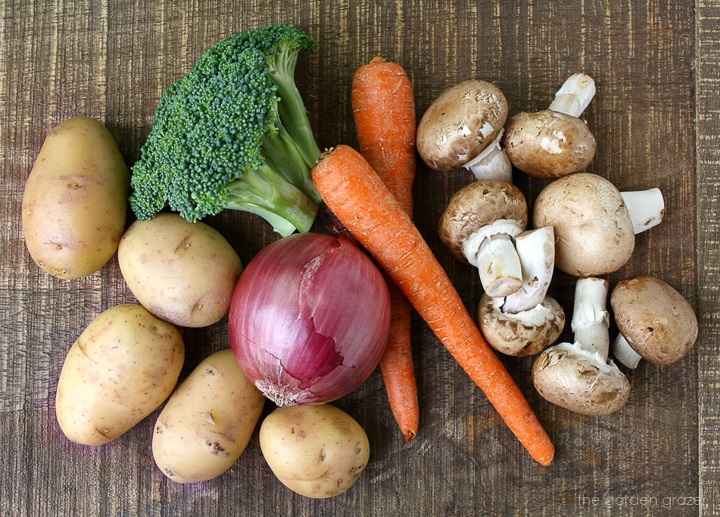

In [5]:
Image.fromarray(cv2.cvtColor(cv2.imread(f"./{pic_string}"), cv2.COLOR_BGR2RGB))

In [6]:
def read_image(image_name):

    # Read image with opencv
    image = cv2.cvtColor(cv2.imread(f"./{image_name}"), cv2.COLOR_BGR2RGB)

    # Extract width and height
    h, w = image.shape[:2]

    # # Read the image using OpenCV and convert it into the PIL format
    return Image.fromarray(image), w, h

In [7]:
def clean_results(results):
    """Clean the results for visualization."""
    return results.strip().removeprefix("```json").removesuffix("```").strip()

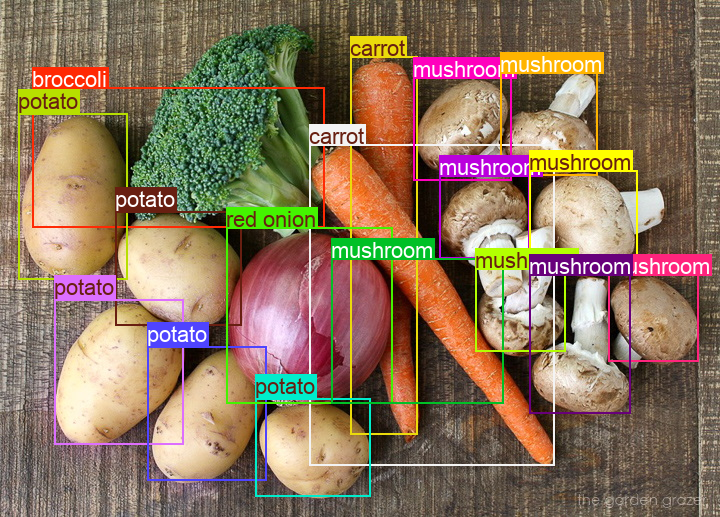

In [8]:
# Define the text prompt
prompt = """
Detect the 2d bounding boxes of all vegetables in this pictures.
"""

# Fixed, plotting function depends on this.
output_prompt = "Return just box_2d and labels, no additional text."

image, w, h = read_image(pic_string)  # Read img, extract width, height

results = inference(image, prompt + output_prompt)  # Perform inference

cln_results = json.loads(clean_results(results))  # Clean results, list convert

annotator = Annotator(image)  # initialize Ultralytics annotator

for idx, item in enumerate(cln_results):
    # By default, gemini model return output with y coordinates first.
    # Scale normalized box coordinates (0–1000) to image dimensions
    y1, x1, y2, x2 = item["box_2d"]  # bbox post processing,
    y1 = y1 / 1000 * h
    x1 = x1 / 1000 * w
    y2 = y2 / 1000 * h
    x2 = x2 / 1000 * w

    if x1 > x2:
        x1, x2 = x2, x1  # Swap x-coordinates if needed
    if y1 > y2:
        y1, y2 = y2, y1  # Swap y-coordinates if needed

    annotator.box_label([x1, y1, x2, y2], label=item["label"], color=colors(idx, True))

Image.fromarray(annotator.result())  # display the output

In [9]:
unique_labels = list({veggie['label'] for veggie in cln_results})
print(unique_labels)

['red onion', 'carrot', 'potato', 'mushroom', 'broccoli']
